<a href="https://colab.research.google.com/github/mashyko/object_detection/blob/master/pytorch_handbook_ssd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SSD code for Pytorch

 Copyright (c) 2017 Max deGroot, Ellis Brown:  Released under the MIT license
 
 https://github.com/amdegroot/ssd.pytorch
 
 Updated by: Takuya Mouri, Copyright (c) 2019
『PyTorchニューラルネットワーク実装ハンドブック』の第７章

Modified by Mashyko

In [0]:
## バージョンを指定する場合、セルをコメントアウトしてください。
#!pip install torch==0.4.1
#!pip install torchvision==0.2.1
#!pip install numpy==1.14.6
#!pip install matplotlib==2.1.2
#!pip install Pillow==5.0.0

In [0]:
# version確認
import torch
print(torch.__version__)

1.4.0


In [0]:
# GPUの接続
import torch
torch.cuda.is_available()

True

In [0]:
!git clone https://github.com/mashyko/pytorch_handbook_ssd

Cloning into 'pytorch_handbook_ssd'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 111 (delta 45), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (111/111), 2.15 MiB | 4.21 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [0]:
# フォルダ移動
%cd /content/pytorch_handbook_ssd

/content/pytorch_handbook_ssd


In [0]:
# ファイル名を表示
!ls

data  layers   README.md	 ssd.py  weights
demo  LICENSE  section7_4.ipynb  utils


# ベースネットVGG-16のパラメータをダウンロード

In [0]:
# ベースネットワークのパラメータファイルをダウンロード
!wget https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth

--2020-04-12 09:05:20--  https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.238.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.238.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81938914 (78M) [binary/octet-stream]
Saving to: ‘vgg16_reducedfc.pth’

vgg16_reducedfc.pth 100%[===================>]  78.14M  27.7MB/s    in 2.8s    

2020-04-12 09:05:23 (27.7 MB/s) - ‘vgg16_reducedfc.pth’ saved [81938914/81938914]



In [0]:
# パラメータファイルをフォルダweightsに移動
!mv vgg16_reducedfc.pth weights

In [0]:
# 学習済みモデルのパラメータファイルをダウンロード
!wget https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth

--2020-04-12 09:05:28--  https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105151288 (100M) [application/x-www-form-urlencoded]
Saving to: ‘ssd300_mAP_77.43_v2.pth’

ssd300_mAP_77.43_v2 100%[===================>] 100.28M  29.2MB/s    in 3.4s    

2020-04-12 09:05:32 (29.2 MB/s) - ‘ssd300_mAP_77.43_v2.pth’ saved [105151288/105151288]



In [0]:
# 学習済みモデルをフォルダweightsに移動
!mv ssd300_mAP_77.43_v2.pth weights

In [0]:
!ls weights/

ssd300_mAP_77.43_v2.pth  vgg16_reducedfc.pth  weight


In [0]:
import os
import sys
module_path = os.path.abspath(os.path.join('/content/pytorch_handbook_ssd'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

In [0]:
# ネットワークの定義
# 引数が'test'だと、推論結果に対してクラスDetectで後処理を実行
ssd_net = build_ssd('test', 300, 21)    # initialize SSD

# GPUの場合、deviceに'cuda'を設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# GPUへの転送
net = ssd_net.to(device)

# 学習済みモデルのロード
net.load_weights('./weights/ssd300_mAP_77.43_v2.pth')
#net.load_weights('../weights/VOC.pth')

Loading weights into state dict...
Finished!


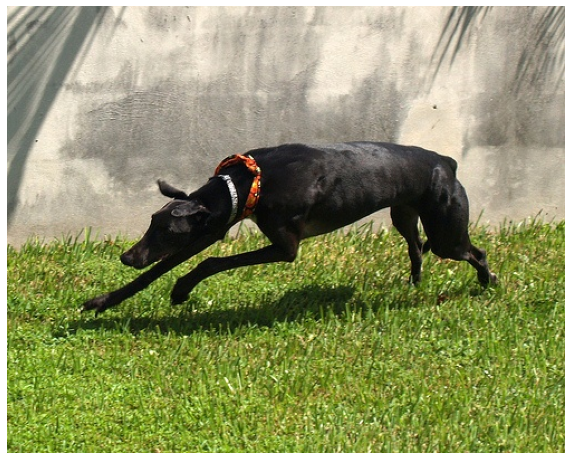

In [0]:
# 画像ファイル名を直接指定
image = cv2.imread('demo/sample.jpg', cv2.IMREAD_COLOR)

%matplotlib inline
from matplotlib import pyplot as plt

# cv2のチャンネルの順番はBGR（青、緑、赤）なので、RGB（赤、緑、青）に入れ替える
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


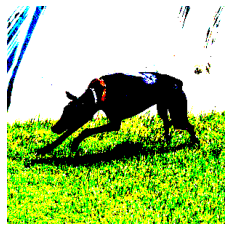

In [0]:
# 画像のサイズを300×300に変更
x = cv2.resize(image, (300, 300)).astype(np.float32)
# 平均のRGBを引く
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
# cv2のチャンネルの順番はBGR（青、緑、赤）なので、RGB（赤、緑、青）に入れ替える
x = x[:, :, ::-1].copy()
plt.axis('off')
plt.imshow(x)
# HWCの形状[300, 300, 3]をCHWの形状[3, 300,300]に変更
x = torch.from_numpy(x).permute(2, 0, 1)

In [0]:
# 0次元目にバッチサイズの次元を追加
# [3, 300, 300]　→　[1, 3, 300, 300] 
xx = x.unsqueeze(0)
# GPUへの転送
xx = xx.to(device)
# dropoutを実行しない
net.eval()
# 計算グラフを作成しない
with torch.no_grad():
  # 順伝播を実行し、推論結果を出力
  y = net(xx)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


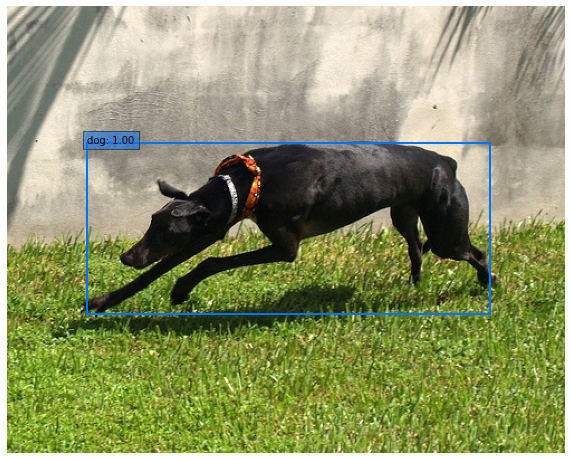

In [0]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.axis('off')
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# 推論結果をdetectionsに格納
detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
# クラスiでループ
for i in range(detections.size(1)):
    j = 0
# 確信度confが0.6以上のボックスを表示
# jは確信度上位200件のボックスのインデックス
# detections[0,i,j]は[conf,xmin,ymin,xmax,ymax]の形状
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

# VOCデータセットのダウンロード

 データセットVOC2007(0.9GB)のダウンロード

In [0]:
# データセットVOC2007をダウンロード 
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar xf VOCtrainval_06-Nov-2007.tar
!rm VOCtrainval_06-Nov-2007.tar

--2020-04-12 09:05:54--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  76.9MB/s    in 5.9s    

2020-04-12 09:06:00 (74.8 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [0]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!tar xf VOCtest_06-Nov-2007.tar
!rm VOCtest_06-Nov-2007.tar

--2020-04-12 09:06:06--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================>] 430.13M  80.2MB/s    in 5.5s    

2020-04-12 09:06:12 (78.5 MB/s) - ‘VOCtest_06-Nov-2007.tar’ saved [451020800/451020800]



 データセットVOC2012(1.9GB)のダウンロード

In [0]:
# データセットVOC2012をダウンロード 
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar xf VOCtrainval_11-May-2012.tar
!rm VOCtrainval_11-May-2012.tar

--2020-04-12 09:06:19--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  75.4MB/s    in 41s     

2020-04-12 09:07:00 (46.7 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



VOCから画像ファイルを取得

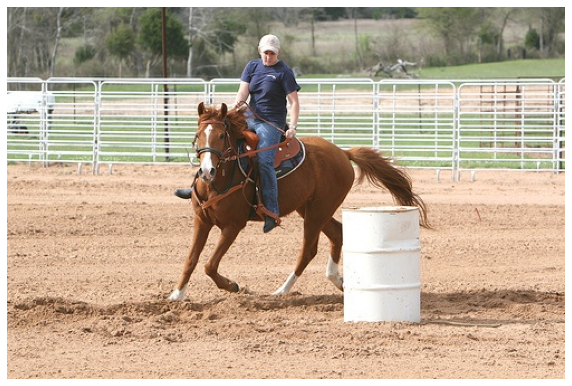

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
testset = VOCDetection(VOC_ROOT, [('2007', 'test')], None, VOCAnnotationTransform())
# クラスVOCDetectionはindexをキーに画像を取得する
img_id = 2586
image = testset.pull_image(img_id)

# cv2のチャンネルの順番はBGR（青、緑、赤）なので、RGB（赤、緑、青）に入れ替える
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


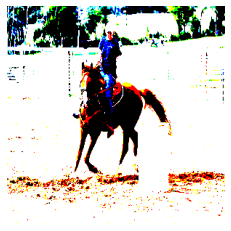

In [0]:
# 画像のサイズを300×300に変更
x = cv2.resize(image, (300, 300)).astype(np.float32)
# 平均のRGBを引く
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
# cv2のチャンネルの順番はBGR（青、緑、赤）なので、RGB（赤、緑、青）に入れ替える
x = x[:, :, ::-1].copy()
plt.axis('off')
plt.imshow(x)
# HWCの形状[300, 300, 3]をCHWの形状[3, 300,300]に変更
x = torch.from_numpy(x).permute(2, 0, 1)

In [0]:
# 0次元目にバッチサイズの次元を追加
# [3, 300, 300]　→　[1, 3, 300, 300] 
xx = x.unsqueeze(0)
# GPUへの転送
xx = xx.to(device)
# dropoutを実行しない
net.eval()
# 計算グラフを作成しない
with torch.no_grad():
  # 順伝播を実行し、推論結果を出力
  y = net(xx)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


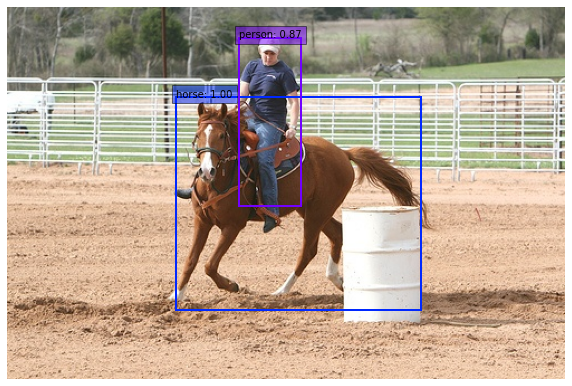

In [0]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.axis('off')
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# 推論結果をdetectionsに格納
detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
# クラスiでループ
for i in range(detections.size(1)):
    j = 0
# 確信度confが0.6以上のボックスを表示
# jは確信度上位200件のボックスのインデックス
# detections[0,i,j]は[conf,xmin,ymin,xmax,ymax]の形状
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

# Pretrained Model を用いた推論：終わり

# SSDネットワークの学習

In [0]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd
import os
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse

In [0]:
# 学習の再開時はargs['resume']にパラメータファイルを指定
args = {'dataset':'VOC',
        'basenet':'vgg16_reducedfc.pth',
        'batch_size':12,
        'resume':'',
        'start_iter':0,
        'num_workers':4,
        'cuda':True,
        'lr':5e-4,
        'momentum':0.9,
        'weight_decay':5e-4,
        'gamma':0.1,
        'save_folder':'weights/'
       }

In [0]:
# Tensor作成時のデフォルトにGPU Tensorを設定
if torch.cuda.is_available():
    if args['cuda']:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if not args['cuda']:
        print("WARNING: It looks like you have a CUDA device, but aren't " +
              "using CUDA.\nRun with --cuda for optimal training speed.")
        torch.set_default_tensor_type('torch.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [0]:
# 訓練データの設定
cfg = voc
dataset = VOCDetection(root=VOC_ROOT,
                       transform=SSDAugmentation(cfg['min_dim'],
                                                 MEANS))

In [0]:
# ネットワークの定義
ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# ネットワークをGPUに転送
net = ssd_net.to(device)

In [0]:
# 学習の再開時はargs['resume']のパラメータをロード
if args['resume']:
    print('Resuming training, loading {}...'.format(args['resume']))
    ssd_net.load_weights(args['save_folder'] + args['resume'])
# 学習の開始時はargs['basenet']のパラメータをロード    
else:
    vgg_weights = torch.load(args['save_folder'] + args['basenet'])
    print('Loading base network...')
    ssd_net.vgg.load_state_dict(vgg_weights)

Loading base network...


In [0]:
# ネットワークのモジュールリストを出力
#print(net)

In [0]:
if args['cuda']:
    net = torch.nn.DataParallel(ssd_net)
    cudnn.benchmark = True

In [0]:
def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed by 10 at every
        specified step
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = args['lr'] * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def xavier(param):
    init.xavier_uniform_(param)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()

In [0]:
# 新規モデル学習時は追加ネットワークの畳み込み、位置推定、クラス分類の畳み込みパラメータを初期化する
if not args['resume']:
    print('Initializing weights...')
    # initialize newly added layers' weights with xavier method
    ssd_net.extras.apply(weights_init)
    ssd_net.loc.apply(weights_init)
    ssd_net.conf.apply(weights_init)

Initializing weights...


In [0]:
# 損失関数の設定
criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                         False, args['cuda'])

In [0]:
# 最適化パラメータの設定
optimizer = optim.SGD(net.parameters(), lr=args['lr'], momentum=args['momentum'],
                      weight_decay=args['weight_decay'])

In [0]:
# 訓練モード
net.train()
# loss counters
loc_loss = 0
conf_loss = 0
epoch = 0
print('Loading the dataset...')

epoch_size = len(dataset) // args['batch_size']
print('dataset_size', len(dataset))
print('epoch_size', epoch_size)
print('Training SSD on:', dataset.name)
print('Using the specified args:')
print(args)

step_index = 0

Loading the dataset...
dataset_size 16551
epoch_size 1379
Training SSD on: VOC0712
Using the specified args:
{'dataset': 'VOC', 'basenet': 'vgg16_reducedfc.pth', 'batch_size': 12, 'resume': '', 'start_iter': 0, 'num_workers': 4, 'cuda': True, 'lr': 0.0005, 'momentum': 0.9, 'weight_decay': 0.0005, 'gamma': 0.1, 'save_folder': 'weights/'}


In [0]:
# 訓練データのデータローダへの設定
data_loader = data.DataLoader(dataset, args['batch_size'],
                              num_workers=args['num_workers'],
                              shuffle=True, collate_fn=detection_collate,
                              pin_memory=True)

In [0]:
# 学習の開始
batch_iterator = None
# iterationでループして、cfg['max_iter']まで学習する
for iteration in range(args['start_iter'], cfg['max_iter']):
    # 学習開始時または1epoch終了後にdata_loaderから訓練データをロードする
    if (not batch_iterator) or (iteration % epoch_size ==0):
        batch_iterator = iter(data_loader)
        loc_loss = 0
        conf_loss = 0
        epoch += 1

    if iteration in cfg['lr_steps']:
        step_index += 1
        adjust_learning_rate(optimizer, args['gamma'], step_index)
        
    # load train data
    # バッチサイズ分の訓練データをload
    images, targets = next(batch_iterator)
    
    # 画像をGPUに転送
    images = images.to(device)
    # アノテーションをGPUに転送    
    targets = [ann.to(device) for ann in targets]

    # forward
    t0 = time.time()
    # 順伝播の計算
    out = net(images)
    # 勾配の初期化
    optimizer.zero_grad()
    # 損失関数の計算
    loss_l, loss_c = criterion(out, targets)
    loss = loss_l + loss_c
    # 勾配の計算
    loss.backward()
    # パラメータの更新
    optimizer.step()
    t1 = time.time()
    # 損失関数の更新
    loc_loss += loss_l.item()
    conf_loss += loss_c.item()
    
    #ログの出力
    if iteration % 10 == 0:
        print('timer: %.4f sec.' % (t1 - t0))
        print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.item()), end=' ')

# 学習済みモデルの保存
torch.save(ssd_net.state_dict(),
           args['save_folder'] + '' + args['dataset'] + '.pth')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


timer: 9.8707 sec.
iter 0 || Loss: 25.6770 || timer: 0.1839 sec.
iter 10 || Loss: 15.4325 || timer: 0.1911 sec.
iter 20 || Loss: 14.4378 || timer: 0.1754 sec.
iter 30 || Loss: 14.1846 || timer: 0.1779 sec.
iter 40 || Loss: 11.9551 || timer: 0.1902 sec.
iter 50 || Loss: 10.3779 || timer: 0.1935 sec.
iter 60 || Loss: 8.7648 || timer: 0.1958 sec.
iter 70 || Loss: 9.0105 || timer: 0.1808 sec.
iter 80 || Loss: 8.4693 || timer: 0.1915 sec.
iter 90 || Loss: 8.7476 || timer: 0.1902 sec.
iter 100 || Loss: 8.2614 || timer: 0.2073 sec.
iter 110 || Loss: 8.0691 || timer: 0.1901 sec.
iter 120 || Loss: 8.1140 || timer: 0.1957 sec.
iter 130 || Loss: 7.4535 || timer: 0.2034 sec.
iter 140 || Loss: 7.2361 || timer: 0.1958 sec.
iter 150 || Loss: 7.9241 || timer: 0.2099 sec.
iter 160 || Loss: 7.2130 || timer: 0.1935 sec.
iter 170 || Loss: 8.5707 || timer: 0.1938 sec.
iter 180 || Loss: 8.4048 || timer: 0.1950 sec.
iter 190 || Loss: 7.0906 || timer: 0.1829 sec.
iter 200 || Loss: 7.7526 || timer: 0.1808 sec.

KeyboardInterrupt: ignored